In [1]:
## This code locates the 1000-m isobath surrounding Antarctica and creates mask_y_transport
## and mask_x_transport masks to apply to the vmo and umo output on the MOM6 C-grid
## so that the net cross-isobath transport can be computed. This code was originally written by and adapted from
## Ruth Moorman at Caltech.

In [2]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import cv2
import matplotlib.path as mpath
 
from xgcm import Grid

# additional configuration (optional)
%config InlineBackend.figure_format = 'retina'

from dask.distributed import Client #client is the interface to
from dask.distributed import LocalCluster #Start the cluster locally
cluster = LocalCluster()
client = Client(cluster) #Connect the client to the c
client

Client Scheduler: tcp://127.0.0.1:43306 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.22 GB


In [3]:
def so_basics(ax,land_mask,geolon,geolat,lat_north=-29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [4]:
#load datasets
ds_static = xr.open_dataset('/net/rlb/subtropical_gyres/mode_water/ocean_monthly.static.nc')
ds_static

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    ...            ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    basin         (yh, xh) int32 ...
Attributes:
    external_variables:  areacello areacello

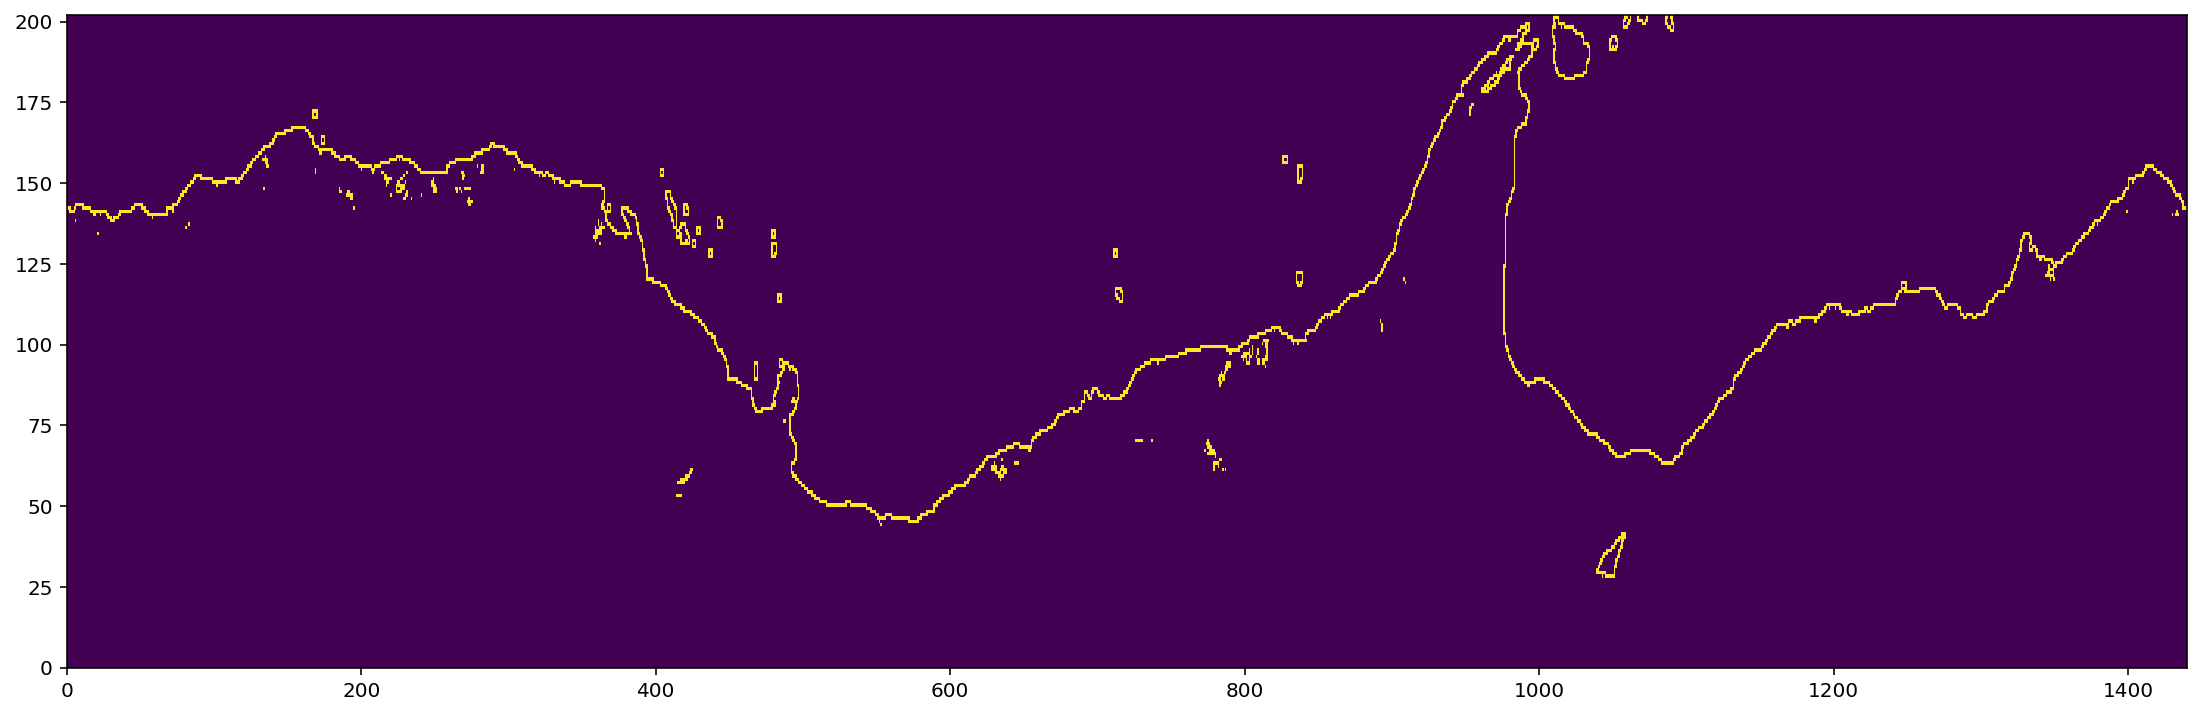

In [5]:
## testing parts of the code in the function below

lat_north = -60

bathy = ds_static.deptho.sel(yh=slice(-90,lat_north))
land_mask = ds_static.wet.sel(yh=slice(-90,lat_north))
geolon = ds_static.geolon.sel(yh = slice(-90,lat_north))
geolat = ds_static.geolat.sel(yh = slice(-90,lat_north))

contour_depth = 1000
lat_north = -60

#Initial basic bathymetry masking
temporary_mask = bathy.copy().fillna(1)
xh = temporary_mask.xh
yh = temporary_mask.yh

temporary_mask = temporary_mask.where(temporary_mask <= contour_depth)*0 + 1 

temporary_mask = temporary_mask.fillna(0) # ocean values filled with zeros
temporary_mask = temporary_mask.values    #extract numpy file

#plt.pcolormesh(temporary_mask) #plot numpy array

# # this spreads the isobath contour so all points are connected adjacently (not just diagonally):
kernel = np.ones((3,3),np.uint8) ## 8 bit unsigned integer type (no sign (+/-) attached), creates a 3 x 3 array of ones

# cv2.dilate = morphological transformation. Needs two inputs: the original image (temporary_mask)
# and the structuring element or kernel which decides the nature of the operation.
# Dilation increases the white region in the image or the size of the foreground object increases.

contour_mask0 = cv2.dilate(temporary_mask,kernel,iterations=1) - temporary_mask
#plt.figure(figsize=[19,6])
#plt.pcolormesh(contour_mask0)

# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(land_mask.values)  #land values zeros
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0] #returns tuple integer positions NOT values where greater than zero along the first column.
                                                               # selects first element of tuple and first element of the array (first element can also be indexed as -1)
contour_mask[contour_lat_index_start,0] = 1                # This is the equivalent of position [142,0]. Make this position = 1.
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_mask0)

In [61]:
def OM4_CM4_Antarctic_Bathymetry_Contour(static, contour_depth,lat_north = -60):

    bathy = ds_static.deptho.sel(yh=slice(-90,lat_north))
    land_mask = ds_static.wet.sel(yh=slice(-90,lat_north))
    geolon = ds_static.geolon.sel(yh = slice(-90,lat_north))
    geolat = ds_static.geolat.sel(yh = slice(-90,lat_north))

    contour_depth = 1000
    lat_north = -60

    #Initial basic bathymetry masking
    temporary_mask = bathy.copy().fillna(1)     #fills land values with ones for bathemetry field
    xh = temporary_mask.xh
    yh = temporary_mask.yh

    temporary_mask = temporary_mask.where(temporary_mask <= contour_depth)*0 + 1 #Antarctic continent and shelf region filled with ones
    temporary_mask = temporary_mask.fillna(0) # ocean values filled with zeros
    temporary_mask = temporary_mask.values    #extract numpy file

    #plt.pcolormesh(temporary_mask) #plot numpy array

    # # this spreads the isobath contour so all points are connected adjacently (not just diagonally):
    kernel = np.ones((4,4),np.uint8) ## 8 bit unsigned integer type (no sign (+/-) attached), creates a 3 x 3 array of ones

    # cv2.dilate = morphological transformation. Needs two inputs: the original image (temporary_mask)
    # and the structuring element or kernel which decides the nature of the operation.
    # Dilation increases the white region in the image or the size of the foreground object increases.

    contour_mask0 = cv2.dilate(temporary_mask,kernel,iterations=1) - temporary_mask
    #plt.figure(figsize=[19,6])
    #plt.pcolormesh(contour_mask0)

    # start at western edge of domain, at y point closest to correct depth contour:
    contour_mask = np.zeros_like(land_mask.values)  #land values zeros
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0] #returns tuple integer positions NOT values where greater than zero along the first column.
                                                               # selects first element of tuple and first element of the array (first element can also be indexed as -1)
    contour_mask[contour_lat_index_start,0] = 1                # This is the equivalent of position [142,0]. Make this position = 1.

    #plt.figure(figsize=[19,6])
    #plt.pcolormesh(contour_mask0)
    
    # loop through to find adjacent point closest to contour depth (do not include previous point):

    last_index_i = 0
    last_index_j = contour_lat_index_start
    count = 0

    while last_index_i<(len(xh)-1): # 1440 is xh dimension length
        
        #This code block says that for the first time don't go backwards:
        
        # If statement says for the first (most west) point, where last_index_i == 0,
        # Create an array called "points to compare" which is composed of 4 elements:
        # 1) The value of the element to the EAST (right)
        # 2) The value of the element to the WEST (left) ---> In this case we set this to zero for the first pt.
        # 3) The value of the element to the NORTH 
        # 4) The value of the element to the SOUTH
        
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                0,
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                contour_mask0[last_index_j,last_index_i-1],
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
            
        # This line, new_loc = np.where(points_to_compare==1) produces a tuple that 
        # contains an array as its first element [0]. The array contains the INDEXES or positions in 
        # the "points to compare" array that have values equal to 1 (i.e, where the 1000 m isobath exists)
        
        # the [0] at the end of the statement says to take the first element of the tuple, which is the array of the 
        # indexes for points where values are 1.
        
        # For the first point, where last_index_i == 0, this results in points_to_compare = array[1,0,0,0]
        # And the the new_loc = array([0]). The new_loc has a length of 1 in this case ... which comes in next 
        # (see below)
        
        new_loc = np.where(points_to_compare==1)[0]
        
        # THIS CODE BLOCK GIVES EACH POINT ALONG THE CONTOUR A UNIQUE INDEX NUMBER:
        
        # In the first if statement, do the following if the length of new_loc == 0, meaning
        # the array contains no elements. This would mean that there are no neighboring cells that have 
        # values of 1. This would indicate a discontinuity in the contour ... I don't think this 
        # is possible so is this necessary?
        
        if len(new_loc)==0:
            contour_mask[last_index_j,last_index_i] = 0
            contour_mask0[last_index_j,last_index_i] = 0
            #contour_mask0[contour_mask==count] = 0
            #print('j'+str(last_index_j)+'i'+str(last_index_i))
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1]
            last_index_j = np.where(contour_mask==count+1)[0]
            continue
        
        # IF length of new_loc > 0, meaning there is at least 1 element in the points_to_compare array
        # equal to 1, thus there is at least one cell to the east, west, north, or south that is along
        # the 1,000 m isobath.
        
        # new_loc is an array that contains the indexes of where in the points_to_compare array that
        # values are equal to one. So, in theory, it can have a length of 0 (no points -- see above), 
        # 1, 2, 3, or 4 (all points) around the value are equal to 1 ... point is completely surrounded. 
        
        elif len(new_loc)>0:
            # if the first element of the array is 0 this means that the
            # point to the east (right) of the cell has value of 1
            # so keep the same y value (last_index_j) but move to the right by one: last_index_i+1
            if new_loc[0] == 0:
                new_index_i = last_index_i+1
                new_index_j = last_index_j
                
            # if the first element of the array is 1 this means that the   
            # point to the west (left) of the cell has value of 1
            # so keep the same y value (last_index_j) but move to the right by one: last_index_i+1 
            elif new_loc[0] == 1:
                new_index_i = last_index_i-1
                new_index_j = last_index_j
                
            # if the first element of the array is 2 this means that the  
            # point to the north of the cell has value of 1
            # so keep the same x value (last_index_i) but move to the north (up) by one: last_index_j+1
            elif new_loc[0] == 2:
                new_index_i = last_index_i
                new_index_j = last_index_j+1
            
            # if the first element of the array is 3 this means that the  
            # point to the south of the cell has value of 1
            # so keep the same x value (last_index_i) but move to the south (down) by one: last_index_j-1
            elif new_loc[0] == 3:
                new_index_i = last_index_i
                new_index_j = last_index_j-1
            
            # The original count = 0, so count + 2 means that the second point on the contour_mask array
            # will be called 2 ... remember above we made the first point = 1. So as we go this will number
            # all the points.
            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            
            # update the indexes to move along the contour
            last_index_j = new_index_j
            last_index_i = new_index_i
            
            # add one to the count value ... it starts at 0, so will go 1, 2, 3 .... 
            # until the while condition at the start of this code block is FALSE.
            count += 1
            
            ### THIS IS THE END OF THE WHILE LOOP.
            
#     # cut out a pesky enclosed loop off the Antarctic Peninsula
#     contour_mask = np.where(np.logical_and(np.greater_equal(contour_mask,1620),np.less_equal(contour_mask,1664)), 0,contour_mask)
#     contour_mask[contour_mask>1664] -= 45
#     # there's another enclosed section of the contour in the ross sea
#     a = np.copy(contour_mask)
#     a[a>760] +=1
#     a[93,477] = 761
#     a = np.where(np.logical_and(np.greater_equal(a,728),np.less_equal(a,760)), 0,a)
#     a[a>760] -= 33
#     contour_mask = a
    
    
    ##############################################################################
    ##############################################################################
    ##############################################################################
    
    # Fill in points to NORTH of contour.
    # This code block creates a mask where values above the 1000 m isobath
    # are equal to -100 and values equal to and below are zero.
    
    
    # this is the sequentially numbered isobath created in the
    # while loop above that provides an along isobath index. It is an array of zeros 
    # EXCEPT for the contour which is 1 through whatever the last index is.
    
    contour_mask_numbered = contour_mask
    
    contour_masked_above = np.copy(contour_mask_numbered)  ## make a copy of the array.
    contour_masked_above[-1,0] = -100                      ## Replace first x point and first y point with -100
    
    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
                    
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
                    
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
                    

                    
    #####################################################################################                    
    #####################################################################################
    
    # separate out points on isobath that will correspond to zonal or meridional transport
    # across contour (i.e. depending on localshape of contour):

    # make masks to multiply x and y transports at correct places:
    mask_x_transport = np.zeros_like(contour_mask_numbered)          #array of zeros with same shape as contour_mask_numbered
    mask_y_transport = np.zeros_like(contour_mask_numbered)          #array of zeros with same shape as contour_mask_numbered
    mask_y_transport_numbered = np.zeros_like(contour_mask_numbered) #array of zeros with same shape as contour_mask_numbered
    mask_x_transport_numbered = np.zeros_like(contour_mask_numbered) #array of zeros with same shape as contour_mask_numbered
    
    # make halos:
    contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],   #create new array of zeros with shape 202 and 1442
        contour_masked_above.shape[1]+2))
    contour_masked_above_halo[:,0] = contour_masked_above[:,-1]            #Entire first column for the first x value equal to is equal to entire first column and first row from the masked_above array?
    contour_masked_above_halo[:,1:-1] = contour_masked_above
    contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

    new_number_count = 1
    for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
        index_i = np.where(contour_mask_numbered==mask_loc)[1]        #Second element of tuple from np.where(contour_mask_numbered==mask_loc)
        index_j = np.where(contour_mask_numbered==mask_loc)[0]        #First element of tuple from np.where(contour_mask_numbered==mask_loc)
        
        # if point above is towards Antarctica and point below is away from Antarctica:
        # take transport grid point to north of t grid:
        if (contour_masked_above[index_j+1,index_i]==0) and \
            (contour_masked_above[index_j-1,index_i]!=0):
            mask_y_transport[index_j,index_i] = -1
            # important to do 
            mask_y_transport_numbered[index_j,index_i] = new_number_count
            new_number_count += 1
            
        # if point below is towards Antarctica and point above is away from Antarctica:
        # take transport grid point to south of t grid:
        elif (contour_masked_above[index_j-1,index_i]==0) and \
            (contour_masked_above[index_j+1,index_i]!=0):
            mask_y_transport[index_j-1,index_i] = 1
            mask_y_transport_numbered[index_j-1,index_i] = new_number_count
            new_number_count += 1
        
        # if point to right is towards Antarctica and point to left is away from Antarctica:
        # zonal indices increased by 1 due to halos
        # take transport grid point on right of t grid:
        if (contour_masked_above_halo[index_j,index_i+2]==0) and \
            (contour_masked_above_halo[index_j,index_i]!=0):
            mask_x_transport[index_j,index_i] = -1
            mask_x_transport_numbered[index_j,index_i] = new_number_count
            new_number_count += 1
        
        # if point to left is towards Antarctica and point to right is away from Antarctica:
        # take transport grid point on left of t grid:
        elif (contour_masked_above_halo[index_j,index_i]==0) and \
            (contour_masked_above_halo[index_j,index_i+2]!=0):
            mask_x_transport[index_j,index_i-1] = 1
            mask_x_transport_numbered[index_j,index_i-1] = new_number_count
            new_number_count += 1
        

    ####################################################################
    ####################################################################
    # Save the arrays created here as xarray dataset
        
    ############## IMPORTANT ######################
    ## The code to create the 1000 m isobath contour puts the masked_y_transport
    ## and masked_x_transport at the correct locations relative to the T cell for
    ## the umo and vmo points. No interpolation should be performed!

    ## The dimensions of the masks are in on the tracer grid (xh,yh). So we need get them
    ## in the correct dimensions to allow multiplication of umo*masked_x_transport, 
    ## vmo*masked_y_transport.

    ## The masks are numpy arrays, so first I need to transform them
    ## into Data Arrays.
    
    mask_y_transport = xr.DataArray(mask_y_transport,dims = ['yh','xh'])
    mask_x_transport = xr.DataArray(mask_x_transport,dims = ['yh','xh'])
    
    mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,dims = ['yh','xh'])
    mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,dims = ['yh','xh'])
    
    static_sliced = ds_static.isel(yh=slice(0,202),yq=slice(0,202)).load()
    static_sliced
    
    static_sliced["mask_for_umo_transports"]=xr.DataArray(mask_x_transport.values,dims=('yh','xq'))
    static_sliced["mask_for_vmo_transports"]=xr.DataArray(mask_y_transport.values,dims=('yq','xh'))
    
    static_sliced["mask_for_umo_transports_numbered"]=xr.DataArray(mask_x_transport_numbered.values,dims=('yh','xq'))
    static_sliced["mask_for_vmo_transports_numbered"]=xr.DataArray(mask_y_transport_numbered.values,dims=('yq','xh'))

    ####################################################################
    ####################################################################
    #### I am not using the other arrays for my computations, so I leave them
    #### on the xh,yh tracer grid.
    
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_mask_numbered.attrs['description'] = '(OM4) Continous circumpolar approximation of the near Antarctic 1000 m isobath. Points on the isobath (tracer points) are numbered sequentially, providing an along-isobath index.'
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    contour_masked_south.attrs['description'] = '(OM4) Masks for the region south of a continous circumpolar approximation of the near Antarctic 1000 m isobath. Tracer points on and polewards of the isobath are 1, points equatorward of the isobath are nan.'
    
    mask_for_vmo_transports = xr.DataArray(static_sliced.mask_for_vmo_transports,dims = ['yq','xh'])
    mask_for_vmo_transports.attrs['description'] = '(OM4) Informs which sign of v (meridional transport) is transport *into* the 1000 m isobath enclosed region. This mask is -1 where positive v denotes transport poleward across the isobath and +1 where positive v denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is zonal (see mask_for_umo_transport). When using this mask, positive cross-isobath transports are offshore.'
    mask_for_umo_transports = xr.DataArray(static_sliced.mask_for_umo_transports,dims = ['yh','xq'])
    mask_for_umo_transports.attrs['description'] = '(OM4) Informs which sign of u (zonal transport) is transport *into* the 1000 m isobath enclosed region. This mask is -1 where positive u denotes transport poleward across the isobath and +1 where positive u denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is meridional (see mask_for_vmo_transport). When using this mask, positive cross-isobath transports are offshore.'
    
    mask_for_vmo_transports_numbered = xr.DataArray(static_sliced.mask_for_vmo_transports_numbered,dims = ['yq','xh'])
    mask_for_vmo_transports_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running east-west (for which cross-isobath transport is meridional transport) included.'
    mask_for_umo_transports_numbered = xr.DataArray(static_sliced.mask_for_umo_transports_numbered,dims = ['yh','xq'])
    mask_for_umo_transports_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running north-south (for which cross-isobath transport is zonal transport) included.'
    
    contour_mask_numbered.coords['geolon'] = geolon
    contour_mask_numbered.coords['geolat'] = geolat
    contour_masked_south.coords['geolon'] = geolon
    contour_masked_south.coords['geolat'] = geolat
    
    ## Not assigning geolat / geolon coords here ... unecessary for what I want to do
    ## but it is important for plotting (so add if thats important, however
    ## the coords will be geolat_v geolon_v geolat_u geolon_u)
    
    #mask_for_vmo_transports.coords['geolon'] = geolon
    #mask_for_vmo_transports.coords['geolat'] = geolat
    #mask_x_transport.coords['geolon'] = geolon
    #mask_x_transport.coords['geolat'] = geolat
    #mask_y_transport_numbered.coords['geolon'] = geolon
    #mask_y_transport_numbered.coords['geolat'] = geolat
    #mask_x_transport_numbered.coords['geolon'] = geolon
    #mask_x_transport_numbered.coords['geolat'] = geolat
    
    return contour_mask_numbered, contour_masked_south, mask_for_vmo_transports, mask_for_umo_transports, mask_for_vmo_transports_numbered, mask_for_umo_transports_numbered

In [72]:
## Call the function
contour_mask_numbered,contour_masked_south,mask_for_vmo_transports,mask_for_umo_transports,mask_for_vmo_transports_numbered,mask_for_umo_transports_numbered  = OM4_CM4_Antarctic_Bathymetry_Contour(ds_static, contour_depth=1000, lat_north = -60)

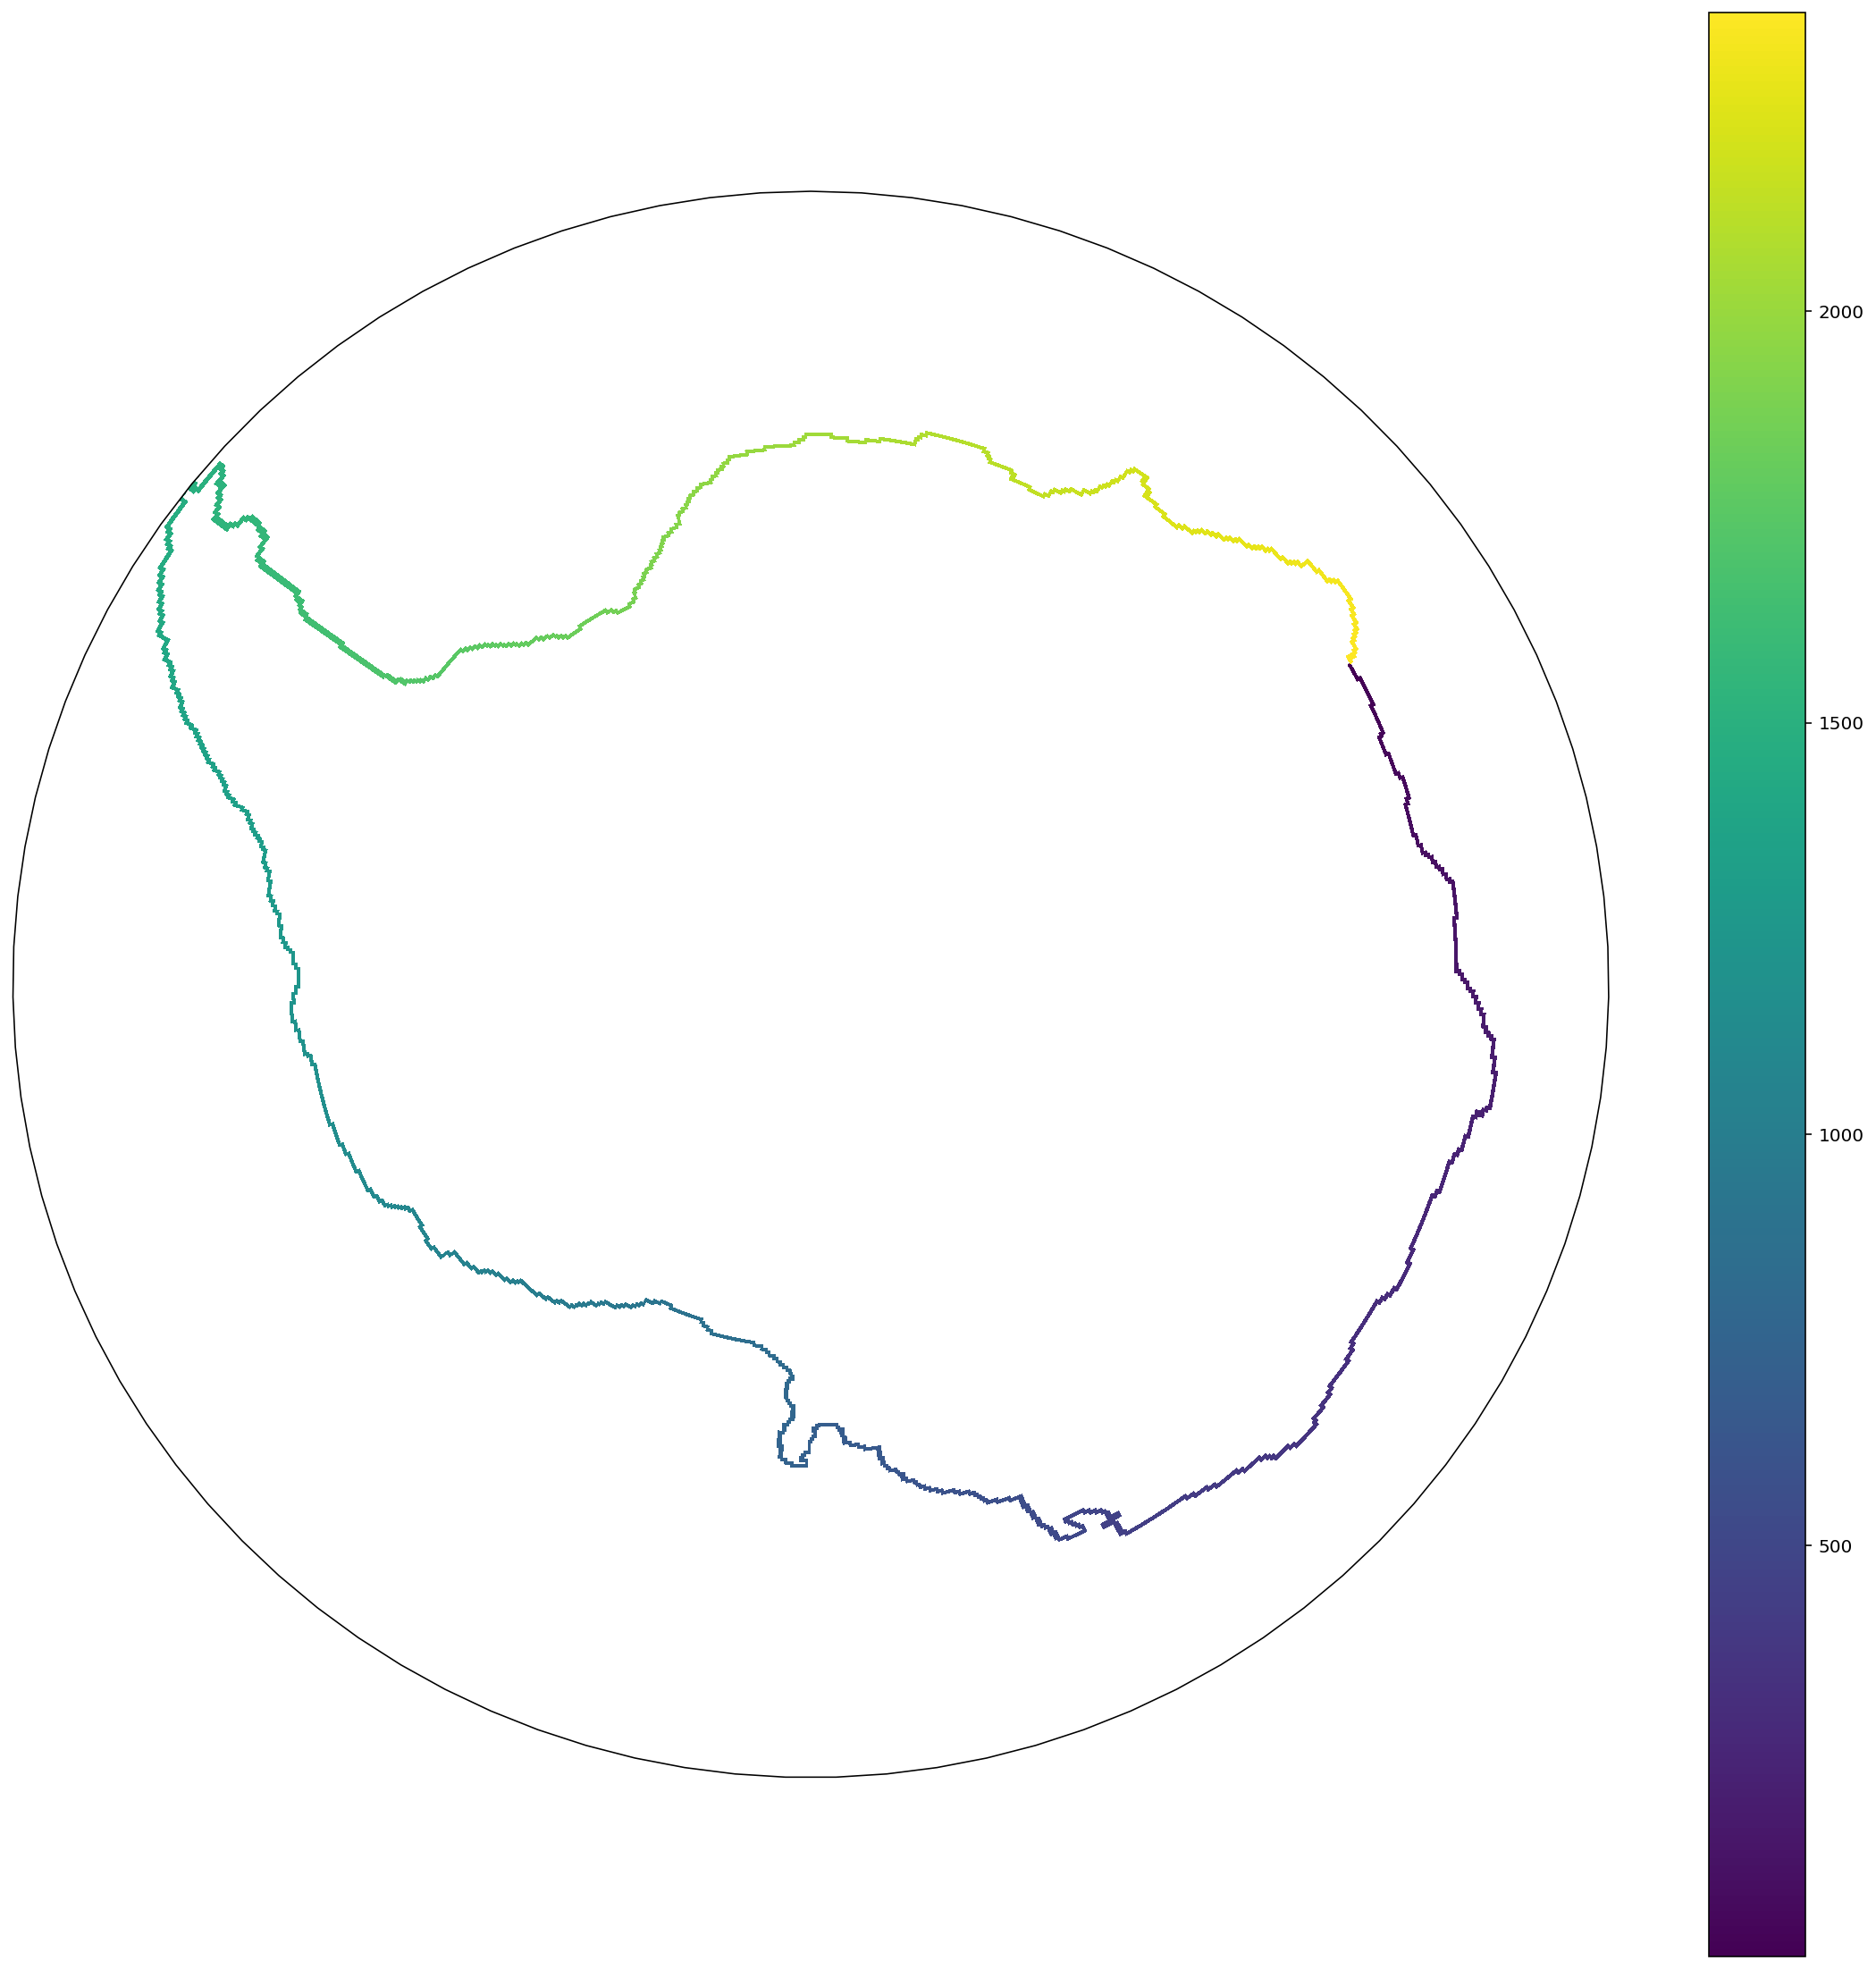

In [73]:
## Plot contour
#land_mask = ds_static.wet.sel(yh = slice(-90,-60)).load()
#geolon = ds_static.geolon.sel(yh = slice(-90,-60)).load()
#geolat = ds_static.geolat.sel(yh = slice(-90,-60)).load()

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=[20, 20])
ax = plt.axes(projection=projection)
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)
p = contour_mask_numbered.where(contour_mask_numbered>0).plot(transform=ccrs.PlateCarree()) 

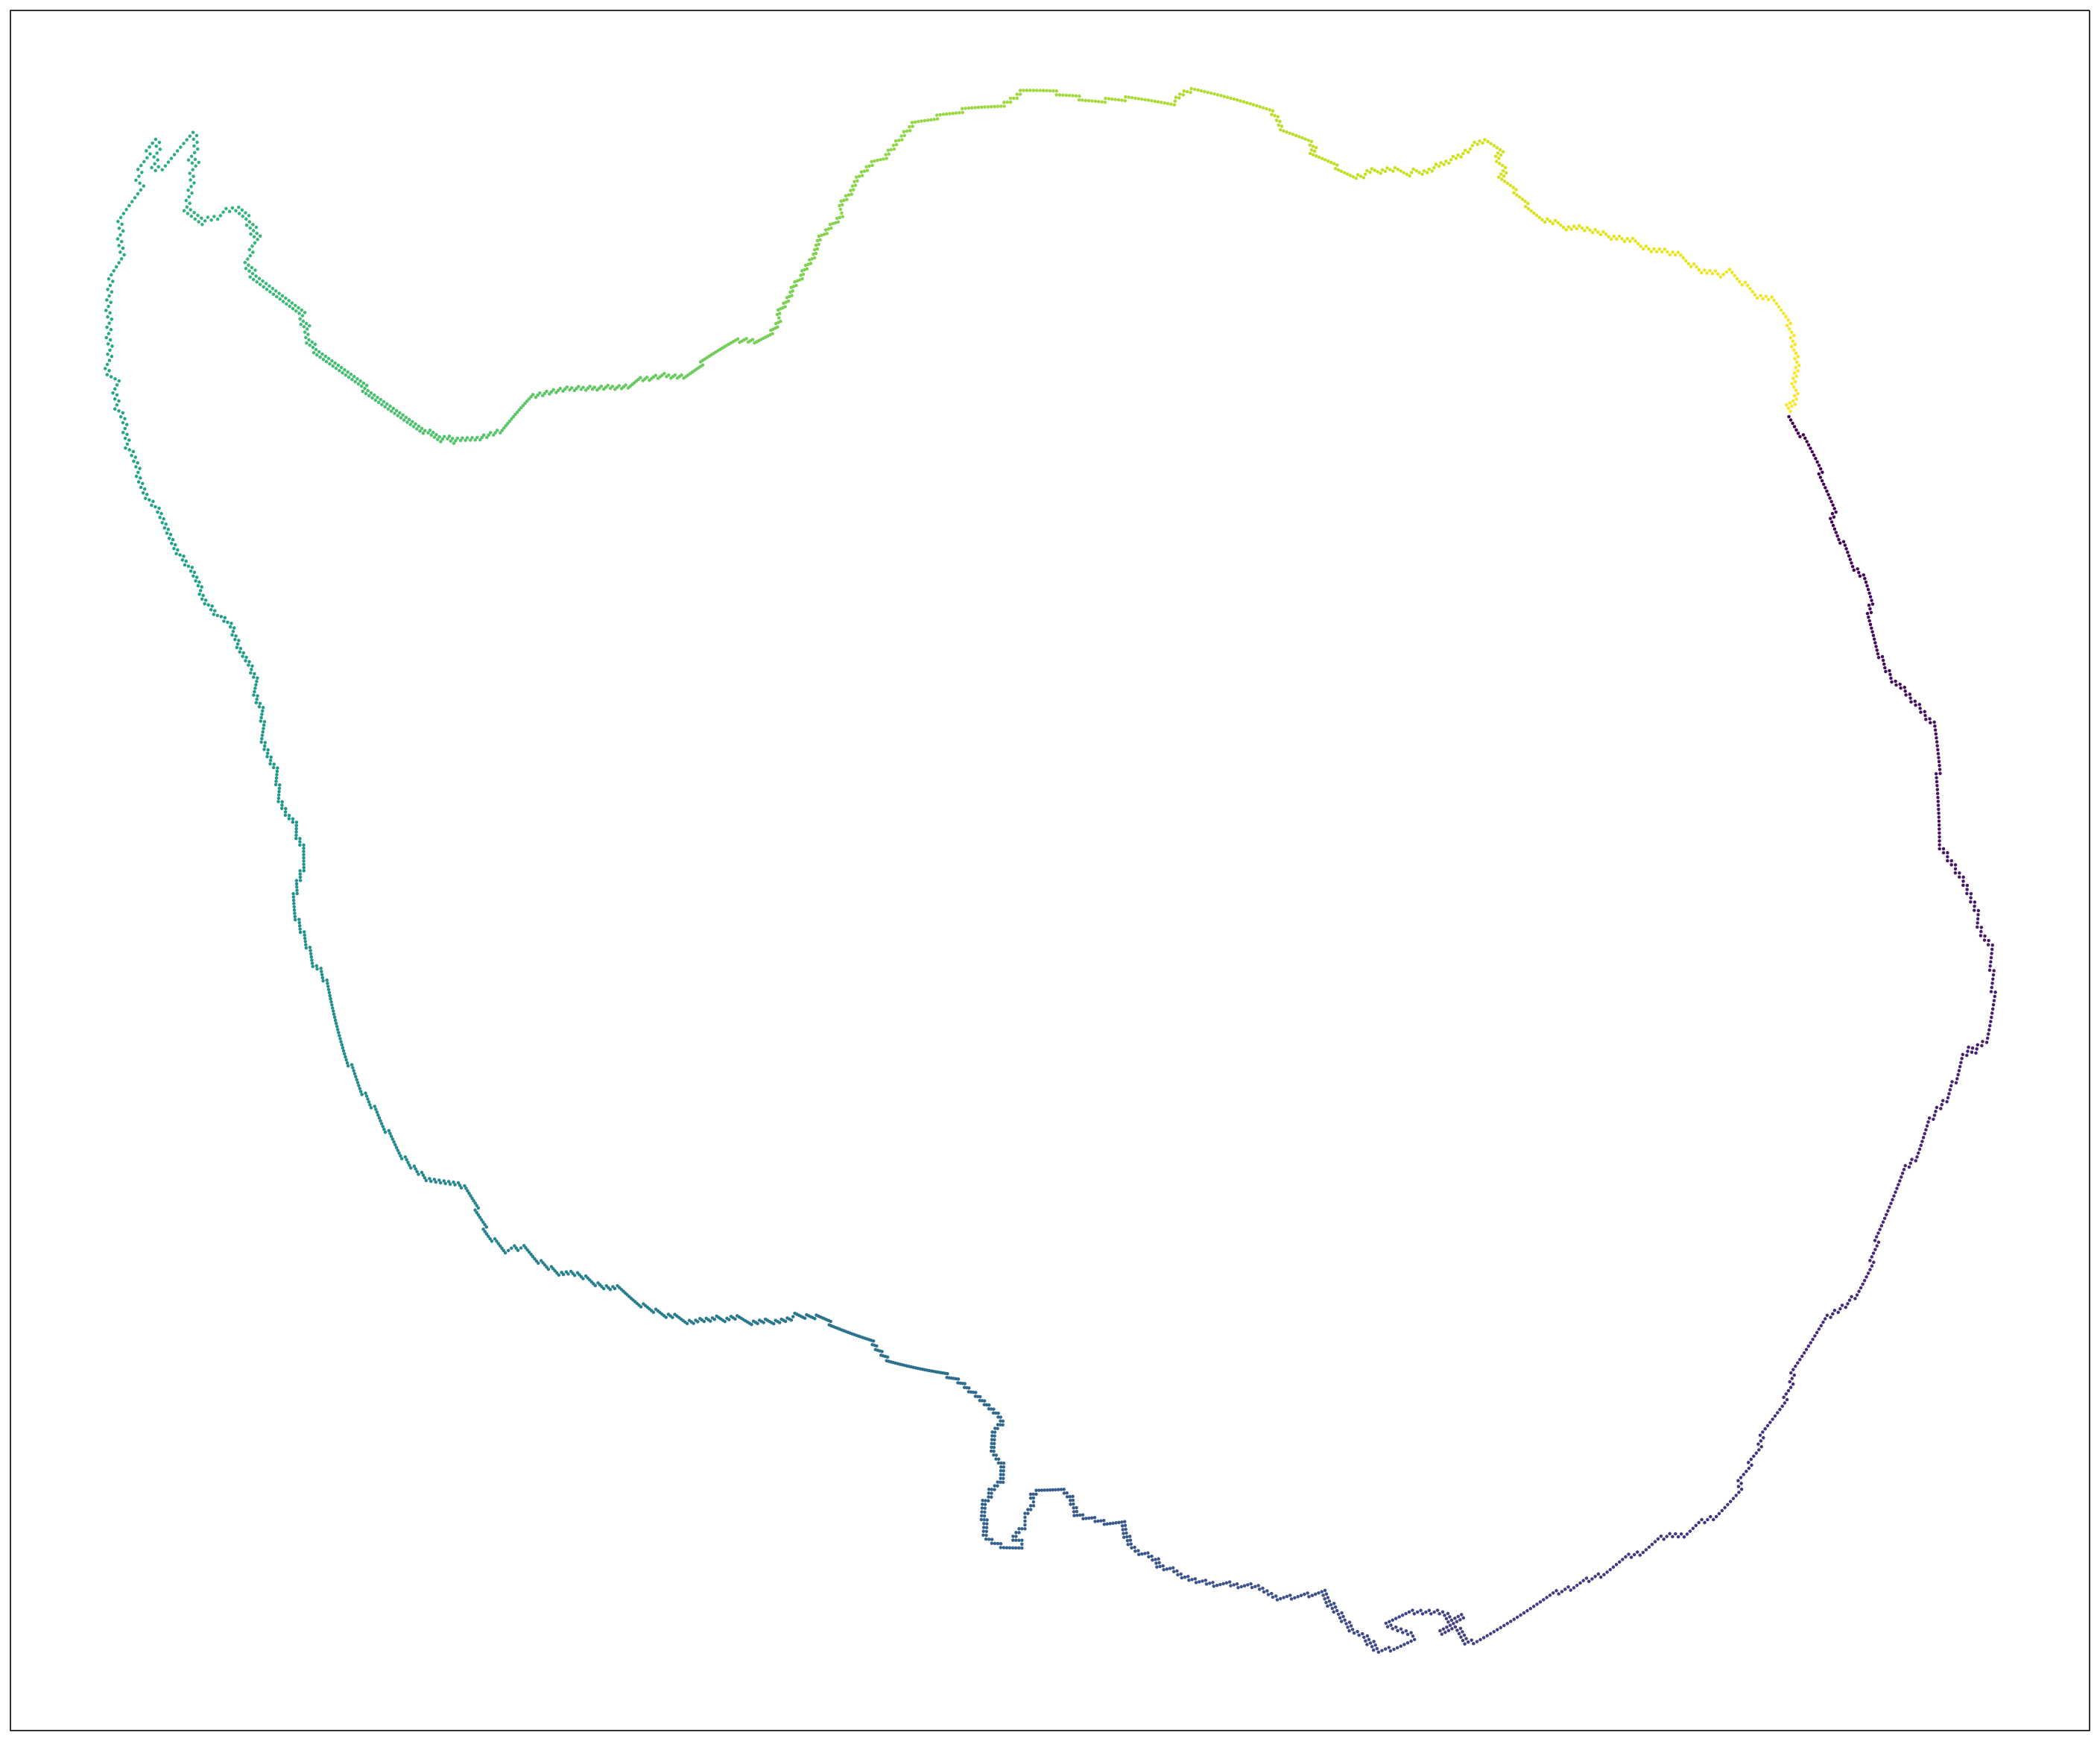

In [74]:
# Investigate the isobath masks to make sure all points are accounted for 
# and region is fully enclosed
# Check contour_mask_numbered
# When I look at this it looks like there are several regions, one being along the isobath
# In the western Weddell Where there are double points?

contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['yh','xh'])
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0,drop=True)

contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
lat_along_contour = contour_index.yh
lon_along_contour = contour_index.xh

fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
plot = ax.scatter(lon_along_contour,lat_along_contour,c=contour_index,transform = ccrs.PlateCarree(),s=1.5)

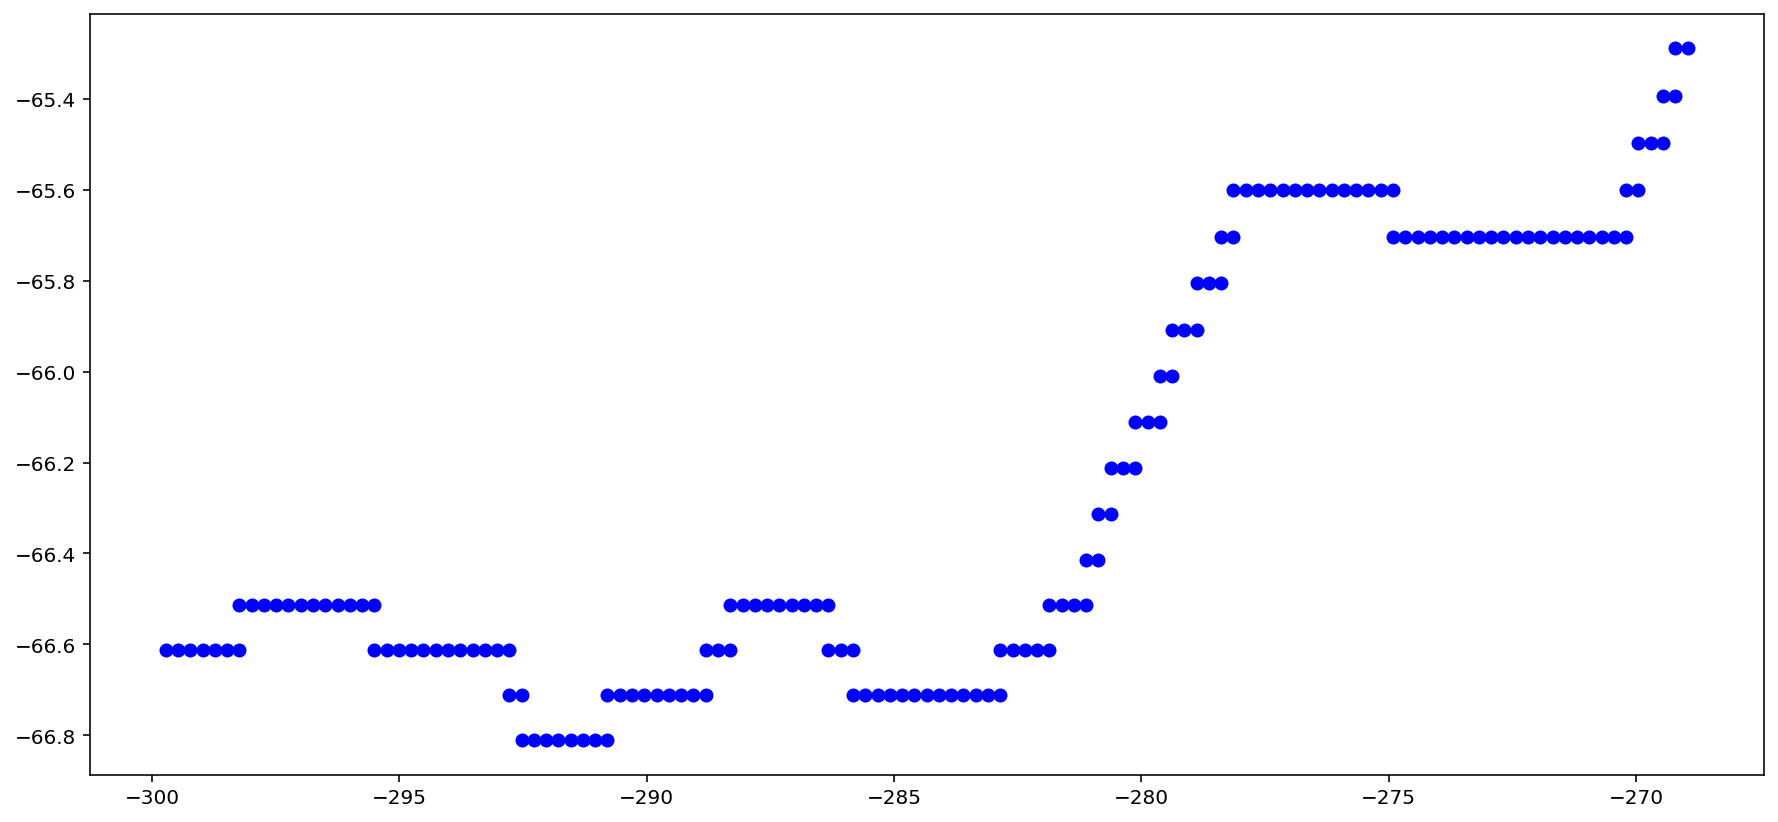

In [75]:
fig = plt.figure(figsize=[15, 7])
ax = plt.subplot()
plot = ax.plot(contour_index.xh[:150],contour_index.yh[:150],'bo')

In [77]:
### Save the created data arrays as a dataset:
ds_all_arrays = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south, 'mask_for_vmo_transports':mask_for_vmo_transports, 'mask_for_umo_transports':mask_for_umo_transports,'mask_for_vmo_transports_numbered':mask_for_vmo_transports_numbered,'mask_for_umo_transports_numbered':mask_for_umo_transports_numbered})


In [78]:
### Save dataset to netcdf file:
ds_all_arrays.to_netcdf('CM4_1000m_Isobath_Contour_Transport_Masks.nc')